In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Data input and preprocessing

# Filenames:
# DEXCAUS.csv  DEXJPUS.csv  DEXMXUS.csv  DEXUSUK.csv DEXCHUS.csv  DEXKOUS.csv  DEXUSEU.csv  DTWEXM.csv

# Reads in currency exchange rate data
filename='DEXUSEU' # Filename
dataset = pd.read_csv('data/'+filename+'.csv') # Reads in CSV file
exchangevalues = dataset.iloc[:, 1:2] # Selects columns

# Replaces missing data (represented by '.') with zeros ('0')
mask=exchangevalues=='.'
exchangevalues[mask] = '0'

# Reformats columns into floats
exchangevalues=np.array(exchangevalues)
exchangevalues=np.matrix([float(x) for x in exchangevalues])
exchangevalues=exchangevalues.transpose()

# Fills in missing and outlier values by taking average between adjacent timesteps
mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
for i in indices:
    # First, checks the initial and final elements of the list
    # If any of these are zero, set them to be equal to their adjacent values
    if i==0:
        exchangevalues[i] = exchangevalues[i+1]
    elif i==len(exchangevalues)-1:
        exchangevalues[i] = exchangevalues[i-1]
    
    # For the rest of the elements, set them to be the average of their adjacent values
    exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 
    
# Initializes the training set
training_set = exchangevalues
N_total_timesteps = len(training_set) # The total number of timesteps in the dataset

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Train/test set parameters
N_timesteps = 60 # Number of timesteps in each training epoch
N_test_timesteps = int(0.15*len(training_set_scaled)) # Number of timesteps for the test set

# Creating a data structure with N timesteps and 1 output
X_train = []
y_train = []
for i in range(N_timesteps, len(training_set)-N_test_timesteps):
    X_train.append(training_set_scaled[i-N_timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(len(training_set)-N_test_timesteps, len(training_set)):
    X_test.append(training_set_scaled[i-N_timesteps:i, 0])
    y_test.append(training_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print('training_set shape',training_set.shape)
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

training_set shape (2610, 1)
X_train shape (2159, 60, 1)
y_train shape (2159, 1)
X_test shape (391, 60, 1)
y_test shape (391, 1)


/home/ansonl/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ansonl/.local/lib/python3.5/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


**Parameter tuning the RNN**

- Increase the number of timesteps. Note that this also tends to increase the phase delay of the prediction.
- Adding more LSTM layers
- Adding more neurons to the LSTM layers
- For parameter tuning, use scoring = 'neg_mean_squared_error'

In [42]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [5]:
# RNN architecture details
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

In [43]:
# Fit the RNN to the Training set
history=regressor.fit(X_train, y_train, validation_split=0.2, epochs = 100, batch_size = 32)

Train on 1727 samples, validate on 432 samples
Epoch 1/100
1727/1727 [==============================] - 16s 9ms/step - loss: 0.0621 - val_loss: 0.0051
Epoch 2/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0093 - val_loss: 0.0033
Epoch 3/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 4/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0064 - val_loss: 7.3266e-04
Epoch 5/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0059 - val_loss: 5.0220e-04
Epoch 6/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 7/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 8/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0057 - val_loss: 3.4454e-04
Epoch 9/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0055 - val_loss: 2.7362e-04
Epoch 10/

1727/1727 [==============================] - 9s 5ms/step - loss: 0.0016 - val_loss: 2.3672e-04
Epoch 77/100
1727/1727 [==============================] - 12s 7ms/step - loss: 0.0015 - val_loss: 3.1526e-04
Epoch 78/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0015 - val_loss: 8.9367e-04
Epoch 79/100
1727/1727 [==============================] - 11s 6ms/step - loss: 0.0016 - val_loss: 1.5236e-04
Epoch 80/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0014 - val_loss: 1.9041e-04
Epoch 81/100
1727/1727 [==============================] - 10s 6ms/step - loss: 0.0013 - val_loss: 5.6344e-04
Epoch 82/100
1727/1727 [==============================] - 10s 6ms/step - loss: 0.0015 - val_loss: 3.5304e-04
Epoch 83/100
1727/1727 [==============================] - 9s 5ms/step - loss: 0.0013 - val_loss: 3.4523e-04
Epoch 84/100
1727/1727 [==============================] - 11s 6ms/step - loss: 0.0013 - val_loss: 1.3850e-04
Epoch 85/100
1727/1727 [============

dict_keys(['loss', 'val_loss'])


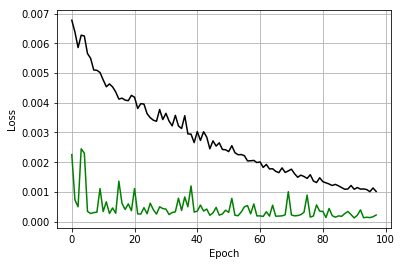

In [48]:
# Plots loss vs. epoch from the training
# live loss plot: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

# list all data in history
print(history.history.keys())

# Sets the number of epochs to exclude at the beginning since they tend to be large
exclude_epochs = 2

plt.plot(history.history['loss'][exclude_epochs:],'k-')
plt.plot(history.history['val_loss'][exclude_epochs:],'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()


In [49]:
# Makes preductions using the test set and the trained RNN model
predicted_values = regressor.predict(X_test)

# Inverts feature scaling transformation
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)
predicted_values = sc.inverse_transform(predicted_values)

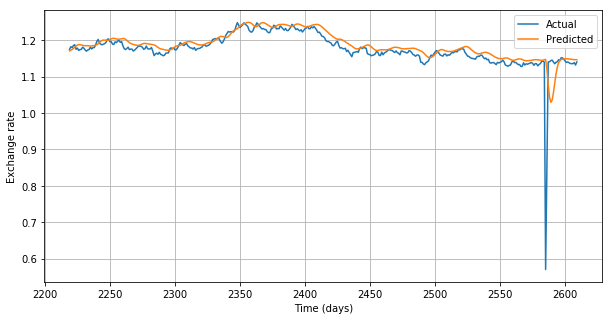

In [64]:
# Does plotting
plt.figure(figsize=(10,5))

#plt.plot(range(N_timesteps, len(training_set)-N_test_timesteps),y_train,label = 'Training data')
x_predicted=np.array(range(len(training_set)-N_test_timesteps, len(training_set)))
plt.plot(x_predicted,y_test,label = 'Actual')
plt.plot(x_predicted,predicted_values+0.02,label = 'Predicted')
#plt.plot(range(len(training_set)-N_test_timesteps, len(training_set)),predicted_values-y_test)


plt.xlabel('Time (days)')
plt.ylabel('Exchange rate')
#plt.ylim(1.2,1.4)
plt.legend()
plt.grid(True)

In [8]:
# Saves the trained RNN model
regressor.save('models/'+filename+'.h5')
print('Model saved')

Model saved
